In [71]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

Le dictionnaire naf_sector_map_fine associe chaque code NAF à un secteur d’activité détaillé (ex. : “Agroalimentaire – Viande et poisson”, “Industrie – Traitement des métaux”). Il constitue une classification fine, précise et granulaire de l’économie selon les activités exercées.

Le dictionnaire naf_sector_map_large regroupe ces secteurs fins en catégories plus larges et cohérentes, telles que “Industrie”, “Services aux entreprises”, “Automotive sector”, etc. Il permet une lecture synthétique et structurée des activités économiques à un niveau plus global.

In [72]:
naf_sector_map_fine = {
    "Agriculture – Grandes cultures": [
        "01.1Ap",  # Culture de céréales ; cultures industrielles
    ],
    "Agriculture – Maraîchage et horticulture": [
        "01.1Cp",  # Culture de légumes ; maraîchage
        "01.1Dp",  # Horticulture ; pépinières
    ],
    "Agriculture – Cultures spécialisées": [
        "01.1Fp",  # Culture fruitière
        "01.1Gp",  # Viticulture
    ],
    "Élevage – Bovins, ovins, caprins": [
        "01.2Ap",  # Élevage de bovins
        "01.2Cp",  # Élevage d'ovins, caprins et équidés
    ],
    "Élevage – Porcins et volailles": [
        "01.2E",   # Élevage de porcins
        "01.2G",   # Élevage de volailles
    ],
    "Élevage – Autres espèces et services associés": [
        "01.2Jp",  # Élevage d'autres animaux
        "01.3Z",   # Culture et élevage associés
        "01.4Ap",  # Services aux cultures productives
        "01.4B",   # Réalisation et entretien de plantations ornementales
        "01.4D",   # Services annexes à l'élevage
    ],
    "Chasse et gestion cynégétique": [
        "01.5Zp",  # Chasse
    ],
    "Forêt et exploitation forestière": [
        "02.0Ap",  # Sylviculture
        "02.0Bp",  # Exploitation forestière
        "02.0D",   # Services forestiers
    ],
    "Pêche et aquaculture": [
        "05.0Ap",  # Pêche
        "05.0Cp",  # Pisciculture, aquaculture
    ],
    "Industrie extractive – Houille, lignite, tourbe": [
        "10.1Zp",  # Extraction et agglomération de la houille
        "10.2Zp",  # Extraction et agglomération du lignite
        "10.3Zp",  # Extraction et agglomération de la tourbe
    ],
    "Industrie extractive – Hydrocarbures": [
        "11.1Zp",  # Extraction d'hydrocarbures
        "11.2Z",   # Services annexes à l'extraction d'hydrocarbures
    ],
    "Industrie extractive – Minerais métalliques": [
        "12.0Zp",  # Extraction de minerais d'uranium
        "13.1Zp",  # Extraction de minerais de fer
        "13.2Zp",  # Extraction de minerais de métaux non ferreux
    ],
    "Industrie extractive – Minéraux non métalliques": [
        "14.1Ap",  # Pierres ornementales et de construction
        "14.1Cp",  # Calcaire, gypse, craie
        "14.1Ep",  # Ardoise
        "14.2Ap",  # Sables et granulats
        "14.2Cp",  # Argiles et kaolin
        "14.3Zp",  # Minéraux pour l'industrie chimique et engrais
        "14.4Zp",  # Production de sel
        "14.5Zp",  # Activités extractives n.c.a.
    ],
    "Industrie – Produits minéraux non métalliques": [
        "26.8C",  # Fabrication de produits minéraux non métalliques
    ],
    "Métallurgie – Sidérurgie et transformation de métaux": [
        "27.1Y",  # Sidérurgie
        "27.2Ap",  # Fabrication de tubes en fonte
        "27.2C",  # Fabrication de tubes en acier
        "27.3A",  # Étirage à froid
        "27.3C",  # Laminage à froid de feuillards
        "27.3E",  # Profilage à froid par formage ou pliage
        "27.3G",  # Tréfilage à froid
    ],
    "Métallurgie – Métaux non ferreux": [
        "27.4A",  # Production de métaux précieux
        "27.4C",  # Production d'aluminium
        "27.4D",  # Première transformation de l'aluminium
        "27.4F",  # Production de plomb, de zinc ou d'étain
        "27.4G",  # Première transformation du plomb, du zinc ou de l'étain
        "27.4J",  # Production de cuivre
        "27.4K",  # Première transformation du cuivre
        "27.4M",  # Métallurgie des autres métaux non ferreux
    ],
    "Métallurgie – Fonderie": [
        "27.5A",  # Fonderie de fonte
        "27.5C",  # Fonderie d'acier
        "27.5E",  # Fonderie de métaux légers
        "27.5G",  # Fonderie d'autres métaux non ferreux
    ],
    "Industrie – Fabrication métallique générale": [
        "28.1Ap",  # Fabrication de constructions métalliques
        "28.1Cp",  # Fabrication de menuiseries et fermetures métalliques
        "28.2Cp",  # Fabrication de réservoirs, citernes et conteneurs métalliques
        "28.2Dp",  # Fabrication de radiateurs et chaudières pour chauffage central
        "28.3Ap",  # Fabrication de générateurs de vapeur
        "28.3Bp",  # Chaudronnerie nucléaire
        "28.3Cp",  # Chaudronnerie-tuyauterie
        "28.4A",  # Forge, estampage, matriçage
        "28.4B",  # Découpage, emboutissage
        "28.4C",  # Métallurgie des poudres
    ],
    "Industrie – Traitement des métaux": [
        "28.5A",  # Traitement et revêtement des métaux
        "28.5C",  # Décolletage
        "28.5Dp",  # Mécanique générale
    ],
    "Industrie – Outillage et articles métalliques": [
        "28.6Ap",  # Fabrication de coutellerie
        "28.6Cp",  # Fabrication d'outillage à main
        "28.6Dp",  # Fabrication d'outillage mécanique
        "28.6Fp",  # Fabrication de serrures et ferrures
        "28.7Ap",  # Fabrication de fûts et emballages métalliques
        "28.7C",   # Fabrication d'emballages métalliques légers
        "28.7E",   # Fabrication d'articles en fils métalliques
        "28.7G",   # Visserie et boulonnerie
        "28.7H",   # Fabrication de ressorts
        "28.7J",   # Fabrication de chaînes
        "28.7Lp",  # Fabrication d'articles métalliques ménagers
        "28.7Np",  # Fabrication de petits articles métalliques
        "28.7Qp",  # Fabrication d'articles métalliques divers
    ],
    "Industrie – Mécanique et moteurs": [
        "29.1Ap",  # Fabrication de moteurs et turbines
        "29.1Bp",  # Fabrication de pompes
        "29.1Dp",  # Fabrication de transmissions hydrauliques et pneumatiques
        "29.1Ep",  # Fabrication de compresseurs
        "29.1Fp",  # Fabrication d'articles de robinetterie
        "29.1Hp",  # Fabrication de roulements
        "29.1Jp",  # Fabrication d'organes mécaniques de transmission
    ],
    "Industrie – Machines industrielles générales": [
        "29.2Ap",  # Fabrication de fours et brûleurs
        "29.2Cp",  # Fabrication d'ascenseurs, monte-charges et escaliers mécaniques
        "29.2Dp",  # Fabrication d'équipements de levage et de manutention
        "29.2Fp",  # Fabrication d'équipements aérauliques et frigorifiques
        "29.2Hp",  # Fabrication d'équipements d'emballage et de conditionnement
        "29.2Jp",  # Fabrication d'appareils de pesage
        "29.2Lp",  # Fabrication de matériels pour les industries chimiques
        "29.2Mp",  # Fabrication d'autres machines d'usage général
    ],
    "Industries diverses – Ameublement, matelas et confort": [
        "36.1M",  # Fabrication de matelas
        "36.1Kp",  # Industries connexes de l'ameublement
    ],
    "Industries diverses – Métaux précieux, bijoux, monnaies": [
        "36.2A",  # Fabrication de monnaies
        "36.2C",  # Bijouterie, joaillerie, orfèvrerie
        "36.6A",  # Bijouterie fantaisie
    ],
    "Industries diverses – Instruments et articles de loisir": [
        "36.3Zp",  # Fabrication d'instruments de musique
        "36.4Zp",  # Fabrication d'articles de sport
        "36.5Zp",  # Fabrication de jeux et jouets
    ],
    "Industries diverses – Autres produits manufacturés": [
        "36.6C",  # Industrie de la brosserie
        "36.6Ep",  # Autres activités manufacturières n.c.a.
    ],
    "Recyclage – Récupération de matériaux": [
        "37.1Zp",  # Récupération de matières métalliques recyclables
        "37.2Zp",  # Récupération de matières non métalliques recyclables
    ],
    "Énergie – Production et distribution": [
        "40.1Ap",  # Production d'électricité
        "40.1C",  # Transport d'électricité
        "40.1Ep",  # Distribution et commerce d'électricité
        "40.2A",  # Production de gaz manufacturé
        "40.2Cp",  # Distribution de combustibles gazeux
        "40.3Z",  # Production et distribution de chaleur
    ],
    "Eau – Captage et distribution": [
        "41.0Zp",  # Captage, traitement et distribution d'eau
    ],
    "Construction – Travaux préparatoires": [
        "45.1Ap",  # Terrassements divers, démolition
        "45.1B",  # Terrassements en grande masse
        "45.1D",  # Forages et sondages
    ],
        "Informatique – Services et maintenance": [
        "72.5Zp",  # Entretien et réparation de machines de bureau
        "72.6Z",   # Autres activités rattachées à l'informatique
    ],
    "Recherche – R&D et études scientifiques": [
        "73.1Zp",  # Recherche-développement en sciences physiques et naturelles
        "73.2Z",   # Recherche-développement en sciences humaines et sociales
    ],
    "Services professionnels – Juridique, comptable, conseil": [
        "74.1A",   # Activités juridiques
        "74.1C",   # Activités comptables
        "74.1E",   # Études de marché et sondages
        "74.1Gp",  # Conseil pour les affaires et la gestion
        "74.1Jp",  # Administration d'entreprises
    ],
    "Services professionnels – Architecture, ingénierie, contrôle": [
        "74.2Ap",  # Activités d'architecture
        "74.2Bp",  # Métreurs, géomètres
        "74.2Cp",  # Ingénierie, études techniques
        "74.3A",   # Contrôle technique automobile
        "74.3B",   # Analyses, essais et inspections techniques
    ],
    "Publicité – Marketing, médias, événements": [
        "74.4Ap",  # Gestion de supports de publicité
        "74.4Bp",  # Agences, conseil en publicité
    ],
    "Ressources humaines – Intérim et recrutement": [
        "74.5Ap",  # Sélection et mise à disposition de personnel
        "74.5B",   # Travail temporaire
    ],
    "Sécurité – Surveillance et protection": [
        "74.6Zp",  # Enquêtes et sécurité
    ],
    "Services aux entreprises – Nettoyage, bureautique, divers": [
        "74.7Zp",  # Activités de nettoyage
        "74.8A",   # Studios et autres activités photographiques
        "74.8B",   # Laboratoires photo
        "74.8D",   # Conditionnement à façon
        "74.8Fp",  # Secrétariat et traduction
        "74.8G",   # Routage
        "74.8H",   # Centres d'appel
        "74.8J",   # Organisation de foires et salons
        "74.8Kp",  # Services annexes à la production
    ],
    "Administration publique – Fonction régalienne": [
        "75.1A",   # Administration publique générale
        "75.1C",   # Tutelle des activités sociales
        "75.1E",   # Tutelle des activités économiques
        "75.1Gp",  # Activités de soutien aux administrations
        "75.2Ap",  # Affaires étrangères
        "75.2C",   # Défense
        "75.2E",   # Justice
        "75.2G",   # Police
        "75.2J",   # Protection civile
    ],
    "Administration publique – Protection sociale": [
        "75.3A",   # Activités générales de sécurité sociale
        "75.3B",   # Gestion des retraites complémentaires
        "75.3C",   # Distribution sociale de revenus
    ],
    "Éducation – Enseignement général et technique": [
        "80.1Zp",  # Enseignement primaire
        "80.2A",   # Enseignement secondaire général
        "80.2C",   # Enseignement secondaire technique ou professionnel
        "80.3Zp",  # Enseignement supérieur
    ],
    "Éducation – Conduite et formation continue": [
        "80.4Ap",  # Écoles de conduite
        "80.4Cp",  # Formation des adultes et formation continue
        "80.4Dp",  # Autres enseignements
    ],
    "Santé – Soins médicaux et paramédicaux": [
        "85.1Ap",  # Activités hospitalières
        "85.1Cp",  # Pratique médicale
        "85.1E",   # Pratique dentaire
        "85.1Gp",  # Activités des auxiliaires médicaux
        "85.1Hp",  # Soins hors d'un cadre réglementé
        "85.1J",   # Ambulances
        "85.1K",   # Laboratoires d'analyses médicales
        "85.1L",   # Centres de collecte et banques d'organes
        "85.2Z",   # Activités vétérinaires
    ],
    "Action sociale – Hébergement et aide à domicile": [
        "85.3Ap",  # Accueil des enfants handicapés
        "85.3Bp",  # Accueil des enfants en difficultés
        "85.3Cp",  # Accueil des adultes handicapés
        "85.3Dp",  # Accueil des personnes âgées
        "85.3Ep",  # Autres hébergements sociaux
        "85.3G",   # Crèches et garderies d'enfants
        "85.3Hp",  # Aide par le travail, ateliers protégés
        "85.3Jp",  # Aide à domicile
        "85.3Kp",  # Autres formes d'action sociale
    ],
    "Environnement – Traitement des déchets et assainissement": [
        "90.0A",   # Collecte et traitement des eaux usées
        "90.0Bp",  # Enlèvement et traitement des ordures ménagères
        "90.0Ep",  # Traitement des autres déchets
        "90.0Gp",  # Autres travaux d'assainissement et de voirie
    ],
    "Associations – Organisations sociales et professionnelles": [
        "91.1A",   # Organisations patronales et consulaires
        "91.1C",   # Organisations professionnelles
        "91.2Z",   # Syndicats de salariés
        "91.3A",   # Organisations religieuses
        "91.3C",   # Organisations politiques
        "91.3E",   # Organisations associatives n.c.a.
    ],
        "Agroalimentaire – Viande et poisson": [
        "15.1Ap",  # Production de viandes de boucherie
        "15.1Cp",  # Production de viandes de volailles
        "15.1Ep",  # Préparation industrielle de produits à base de viandes
        "15.1Fp",  # Charcuterie
        "15.2Zp",  # Industrie du poisson
    ],
    "Agroalimentaire – Fruits, légumes et pommes de terre": [
        "15.3Ap",  # Transformation et conservation de pommes de terre
        "15.3Ep",  # Transformation et conservation de légumes
        "15.3Fp",  # Transformation et conservation de fruits
        "15.3C",   # Préparation de jus de fruits et légumes
    ],
    "Agroalimentaire – Huiles et matières grasses": [
        "15.4A",  # Fabrication d'huiles et graisses brutes
        "15.4C",  # Fabrication d'huiles et graisses raffinées
        "15.4E",  # Fabrication de margarine
    ],
    "Agroalimentaire – Produits laitiers": [
        "15.5A",  # Fabrication de lait liquide et de produits frais
        "15.5B",  # Fabrication de beurre
        "15.5C",  # Fabrication de fromages
        "15.5D",  # Fabrication d'autres produits laitiers
        "15.5F",  # Fabrication de glaces et sorbets
    ],
    "Agroalimentaire – Meunerie et produits céréaliers": [
        "15.6A",  # Meunerie
        "15.6B",  # Autres activités de travail des grains
        "15.6Dp", # Fabrication de produits amylacés
    ],
    "Agroalimentaire – Aliments pour animaux": [
        "15.7A",  # Fabrication d'aliments pour animaux de ferme
        "15.7C",  # Fabrication d'aliments pour animaux de compagnie
    ],
    "Agroalimentaire – Boulangerie, pâtisserie, sucrerie": [
        "15.8Ap",  # Fabrication industrielle de pain et de pâtisserie fraîche
        "15.8Bp",  # Cuisson de produits de boulangerie
        "15.8Cp",  # Boulangerie et boulangerie-pâtisserie
        "15.8Dp",  # Pâtisserie
        "15.8F",   # Biscotterie, biscuiterie, pâtisserie de conservation
        "15.8H",   # Fabrication de sucre
    ],
    "Agroalimentaire – Confiserie, pâtes et autres": [
        "15.8K",   # Chocolaterie, confiserie
        "15.8Mp",  # Fabrication de pâtes alimentaires
        "15.8P",   # Transformation du thé et du café
        "15.8R",   # Fabrication de condiments et assaisonnements
        "15.8T",   # Aliments adaptés à l'enfant et diététiques
        "15.8Vp",  # Industries alimentaires n.c.a.
    ],
    "Boissons": [
        "15.9A",  # Production d'eaux de vie naturelles
        "15.9B",  # Fabrication de spiritueux
        "15.9Dp", # Production d'alcool éthylique de fermentation
        "15.9F",  # Champagnisation
        "15.9G",  # Vinification
        "15.9J",  # Cidrerie
        "15.9L",  # Autres boissons fermentées
        "15.9N",  # Brasserie
        "15.9Q",  # Malterie
        "15.9S",  # Industrie des eaux de table
        "15.9T",  # Boissons rafraîchissantes
    ],
    "Industrie du tabac": [
        "16.0Z",  # Industrie du tabac
    ],
    "Textile – Filature et tissage": [
        "17.1A",  # Filature de l'industrie cotonnière
        "17.1C",  # Filature de l'industrie lainière - cycle cardé
        "17.1E",  # Préparation de la laine
        "17.1F",  # Filature de l'industrie lainière - cycle peigné
        "17.1H",  # Préparation et filature du lin
        "17.1K",  # Moulinage/texturation soie/textiles artificiels/synthétiques
        "17.1M",  # Fabrication de fils à coudre
        "17.1P",  # Préparation et filature d'autres fibres
        "17.2A",  # Tissage de l'industrie cotonnière
        "17.2C",  # Tissage de l'industrie lainière - cycle cardé
        "17.2E",  # Tissage de l'industrie lainière - cycle peigné
        "17.2G",  # Tissage de soieries
        "17.2J",  # Tissage d'autres textiles
    ],
    "Textile – Ennoblissement et confection textile": [
        "17.3Z",   # Ennoblissement textile
        "17.4Ap",  # Fabrication de linge de maison et articles d'ameublement
        "17.4Bp",  # Fabrication de petits articles textiles de literie
        "17.4Cp",  # Autres articles confectionnés en textile
    ],
    "Textile – Fabrication spécialisée": [
        "17.5A",   # Fabrication de tapis et moquettes
        "17.5Cp",  # Ficellerie, corderie, filets
        "17.5E",   # Fabrication de non-tissés
        "17.5Gp",  # Industrie textile n.c.a.
        "17.6Z",   # Fabrication d'étoffes à mailles
        "17.7Ap",  # Fabrication de bas et chaussettes
        "17.7C",   # Fabrication de pull-overs et articles similaires
    ],
    "Habillement, cuir et chaussures": [
        "18.1Zp",  # Fabrication de vêtements en cuir
        "18.2A",   # Fabrication de vêtements de travail
        "18.2C",   # Fabrication de vêtements sur mesure
        "18.2D",   # Vêtements de dessus hommes et garçons
        "18.2E",   # Vêtements de dessus femmes et fillettes
        "18.2G",   # Vêtements de dessous
        "18.2Jp",  # Autres vêtements et accessoires
        "18.3Zp",  # Industrie des fourrures
        "19.1Z",   # Apprêt et tannage des cuirs
        "19.2Z",   # Articles de voyage et maroquinerie
        "19.3Zp",  # Fabrication de chaussures
    ],
    "Bois, papier et imprimerie": [
        "20.1A",  # Sciage et rabotage du bois
        "20.1B",  # Imprégnation du bois
        "20.2Z",  # Fabrication de panneaux de bois
        "20.3Zp", # Charpentes et menuiseries
        "20.4Zp", # Emballages en bois
        "20.5Ap", # Objets divers en bois
        "20.5Cp", # Liège, vannerie, sparterie
        "21.1A",  # Pâte à papier
        "21.1C",  # Papier et carton
        "21.2A",  # Carton ondulé
        "21.2B",  # Cartonnages
        "21.2C",  # Emballages papier
        "21.2Ep", # Papier à usage sanitaire ou domestique
        "21.2G",  # Papeterie
        "21.2J",  # Papiers peints
        "21.2Lp", # Autres articles en papier/carton
        "22.1Ap", # Édition de livres
        "22.1C",  # Édition de journaux
        "22.1E",  # Revues et périodiques
        "22.1G",  # Enregistrements sonores
        "22.1J",  # Autres activités d’édition
        "22.2A",  # Imprimerie de journaux
        "22.2Cp", # Autre imprimerie (labeur)
        "22.2E",  # Reliure
        "22.2G",  # Activités de pré-presse
        "22.2J",  # Activités graphiques auxiliaires
        "22.3A",  # Reproduction de sons
        "22.3C",  # Reproduction de vidéos
        "22.3E",  # Reproduction informatique
    ],
    "Industrie de la cokéfaction et raffinage": [
        "23.1Z",  # Cokéfaction
        "23.2Z",  # Raffinage de pétrole
        "23.3Zp", # Matières nucléaires
    ],
    "Chimie et produits chimiques": [
        "24.1A",  # Gaz industriels
        "24.1C",  # Colorants et pigments
        "24.1E",  # Produits chimiques inorganiques
        "24.1Gp", # Produits chimiques organiques
        "24.1Jp", # Produits azotés et engrais
        "24.1L",  # Matières plastiques de base
        "24.1N",  # Caoutchouc synthétique
        "24.2Z",  # Produits agrochimiques
        "24.3Z",  # Peintures et vernis
        "24.4A",  # Produits pharmaceutiques de base
        "24.4C",  # Médicaments
        "24.4Dp", # Autres produits pharmaceutiques
        "24.5Ap", # Savons, détergents, entretien
        "24.5C",  # Parfums et produits de toilette
        "24.6A",  # Produits explosifs
        "24.6Cp", # Colles et gélatines
        "24.6E",  # Huiles essentielles
        "24.6G",  # Produits pour la photographie
        "24.6J",  # Supports de données
        "24.6Lp", # Produits chimiques industriels
        "24.7Z",  # Fibres artificielles ou synthétiques
    ],
    "Caoutchouc et plastiques": [
        "25.1A",  # Pneumatiques
        "25.1C",  # Rechapage de pneumatiques
        "25.1Ep", # Autres articles en caoutchouc
        "25.2Ap", # Plaques, feuilles, tubes plastiques
        "25.2C",  # Emballages plastiques
        "25.2Ep", # Éléments plastiques pour construction
        "25.2Gp", # Articles divers plastiques
        "25.2Hp", # Pièces techniques plastiques
    ],
    "Verre et céramique": [
        "26.1A",  # Verre plat
        "26.1C",  # Façonnage verre plat
        "26.1E",  # Verre creux
        "26.1G",  # Fibres de verre
        "26.1Jp", # Autres articles techniques en verre
        "26.1K",  # Isolateurs en verre
        "26.2A",  # Articles céramiques domestiques
        "26.2C",  # Appareils sanitaires en céramique
        "26.2Ep", # Isolateurs céramique
        "26.2G",  # Céramiques techniques
        "26.2J",  # Autres produits céramiques
        "26.2L",  # Céramiques réfractaires
        "26.3Z",  # Carreaux en céramique
    ],
    "Matériaux de construction (hors céramique)": [
        "26.4A",  # Briques
        "26.4B",  # Tuiles
        "26.4Cp", # Produits divers en terre cuite
        "26.5A",  # Ciment
        "26.5C",  # Chaux
        "26.5E",  # Plâtre
        "26.6A",  # Éléments béton construction
        "26.6C",  # Éléments plâtre construction
        "26.6E",  # Béton prêt à l'emploi
        "26.6G",  # Mortiers et bétons secs
        "26.6J",  # Ouvrages en fibre-ciment
        "26.6L",  # Autres ouvrages béton/plâtre
        "26.7Z",  # Taille/finissage pierres
        "26.8Ap", # Produits abrasifs
    ],
    "Fabrication de machines et équipements industriels": [
        "29.3Ap",  # Tracteurs agricoles
        "29.3Cp",  # Réparation matériel agricole
        "29.3Dp",  # Matériel agricole
        "29.4Ap",  # Machines-outils à métaux
        "29.4Bp",  # Machines-outils à bois
        "29.4Cp",  # Machines-outils portatives
        "29.4Dp",  # Matériel de soudage
        "29.4Ep",  # Autres machines-outils
        "29.5Ap",  # Machines pour métallurgie
        "29.5Bp",  # Matériels de mine
        "29.5Dp",  # Travaux publics
        "29.5Ep",  # Machines agroalimentaires
        "29.5Gp",  # Machines textiles
        "29.5Jp",  # Machines papier/carton
        "29.5Lp",  # Machines imprimerie
        "29.5Mp",  # Machines caoutchouc/plastiques
        "29.5N",   # Moules et modèles
        "29.5Qp",  # Machines assemblage automatique
        "29.5Rp",  # Machines spécialisées diverses
        "29.6Ap",  # Armement
        "29.6Bp",  # Armes de chasse/défense
    ],
    "Électroménager et électronique": [
        "29.7Ap",  # Appareils électroménagers
        "29.7Cp",  # Appareils non électriques
        "30.0Ap",  # Machines de bureau
        "30.0Cp",  # Ordinateurs et équipements IT
    ],
    "Équipements électriques": [
        "31.1Ap",  # Moteurs/générateurs moyenne puissance
        "31.1Bp",  # Moteurs/générateurs grande puissance
        "31.1Cp",  # Réparation matériels électriques
        "31.2Ap",  # Distribution basse tension
        "31.2Bp",  # Distribution haute tension
        "31.3Zp",  # Fils et câbles isolés
        "31.4Z",   # Accumulateurs et piles
        "31.5A",   # Lampes
        "31.5B",   # Appareils sécurité autonomes
        "31.5C",   # Appareils d'éclairage
        "31.6Ap",  # Équipements électriques véhicules
        "31.6Cp",  # Électromagnétisme industriel
        "31.6Dp",  # Équipements électriques n.c.a.
    ],
    "Composants électroniques et communication": [
        "32.1Ap",  # Composants passifs
        "32.1Cp",  # Composants électroniques actifs
        "32.1D",   # Assemblage de cartes électroniques
        "32.2Ap",  # Équipements transmission hertzienne
        "32.2Bp",  # Appareils téléphonie
        "32.3Zp",  # Appareils son/image (réception, enregistrement)
    ],
    "Appareils médicaux et instruments scientifiques": [
        "33.1Ap",  # Imagerie médicale/radiologie
        "33.1Bp",  # Appareils médicaux-chirurgicaux
        "33.2Ap",  # Équipements navigation
        "33.2Bp",  # Instruments scientifiques/techniques
        "33.3Z",   # Contrôle des processus industriels
        "33.4A",   # Fabrication de lunettes
        "33.4Bp",  # Instruments optiques/photo
    ],
    "Horlogerie": [
        "33.5Zp",  # Horlogerie
    ],
    "Automobile & véhicules" : [
    "34.1Zp",  # Construction de véhicules automobiles
    "34.2Ap",  # Fabrication de carrosseries automobiles
    "34.2B",   # Fabrication de caravanes et véhicules de loisirs
    "34.3Zp",  # Fabrication d'équipements automobiles
    "35.4A",   # Fabrication de motocycles
    "35.4C",   # Fabrication de bicyclettes
    "35.4Ep",  # Fabrication de véhicules pour invalides
    "35.5Zp",  # Fabrication de matériels de transport n.c.a.
    ],
    "Transport lourd & spécialisé" : [
    "35.1A",   # Construction de bâtiments de guerre
    "35.1B",   # Construction de navires civils
    "35.1Cp",  # Réparation navale
    "35.1Ep",  # Construction de bateaux de plaisance
    "35.2Zp",  # Construction de matériel ferroviaire roulant
    "35.3Ap",  # Construction de moteurs pour aéronefs
    "35.3Bp",  # Construction de cellules d'aéronefs
    "35.3C",   # Construction de lanceurs et engins spatiaux
    ],
    "Fabrication de meubles": [
        "36.1Ap", "36.1Cp", "36.1E", "36.1G", "36.1H", "36.1J",
    ],
    "BTP – Gros œuvre" : [
    "45.2Ap",  # Construction de maisons individuelles
    "45.2Bp",  # Construction de bâtiments divers
    "45.2Cp",  # Construction d'ouvrages d'art
    "45.2Dp",  # Travaux souterrains
    "45.2E",   # Réalisation de réseaux
    "45.2F",   # Construction de lignes électriques et de télécommunication
    "45.2J",   # Travaux de couverture par éléments
    "45.2K",   # Travaux d'étanchéification
    "45.2L",   # Travaux de charpente
    "45.2N",   # Construction de voies ferrées
    "45.2Pp",  # Construction de chaussées routières et sols sportifs
    "45.2Rp",  # Travaux maritimes et fluviaux
    "45.2T",   # Levage, montage
    "45.2Up",  # Autres travaux spécialisés de construction
    "45.2V",   # Travaux de maçonnerie générale
    ],
    "BTP – Second œuvre" : [
    "45.3Ap",  # Travaux d'installation électrique
    "45.3C",   # Travaux d'isolation
    "45.3E",   # Installation d'eau et de gaz
    "45.3F",   # Installation d'équipements thermiques et climatisation
    "45.3Hp",  # Autres travaux d'installation
    "45.4A",   # Plâtrerie
    "45.4C",   # Menuiserie bois et matières plastiques
    "45.4D",   # Menuiserie métallique ; serrurerie
    "45.4F",   # Revêtement des sols et des murs
    "45.4H",   # Miroiterie, vitrerie
    "45.4J",   # Peinture
    "45.4L",   # Agencement de lieux de vente
    "45.4Mp",  # Travaux de finition n.c.a.
    "45.5Z",   # Location avec opérateur de matériel de construction
    ],
    
    "Commerce automobile": [
    "50.1Zp",  # Commerce de véhicules automobiles
    "50.2Zp",  # Entretien et réparation de véhicules automobiles
    "50.3A",   # Commerce de gros d'équipements automobiles
    "50.3B",   # Commerce de détail d'équipements automobiles
    "50.4Z",   # Commerce et réparation de motocycles
    "50.5Z",   # Commerce de détail de carburants
    ],
    "Intermédiation commerciale": [
    "51.1A",  # Intermédiaires produits agricoles, animaux, textiles
    "51.1C",  # Intermédiaires combustibles, métaux, minéraux
    "51.1E",  # Intermédiaires bois, matériaux de construction
    "51.1G",  # Intermédiaires machines, équipements industriels
    "51.1J",  # Intermédiaires meubles, articles de ménage
    "51.1L",  # Intermédiaires textiles, habillement, chaussures
    "51.1N",  # Intermédiaires produits alimentaires
    "51.1P",  # Centrales d'achats alimentaires
    "51.1R",  # Autres intermédiaires spécialisés
    "51.1T",  # Intermédiaires non spécialisés
    "51.1Up", # Centrales d'achats non alimentaires
    ],
    "Commerce de gros – Produits agricoles et alimentaires": [
    "51.2A",  # Céréales, aliments pour bétail
    "51.2C",  # Fleurs et plantes
    "51.2E",  # Animaux vivants
    "51.2G",  # Cuirs et peaux
    "51.2J",  # Tabac non manufacturé
    "51.3Ap", "51.3C", "51.3D", "51.3E", "51.3G", "51.3Jp", "51.3L", "51.3N",
    "51.3Q", "51.3S", "51.3T", "51.3V", "51.3W",  # Viandes, produits laitiers, boissons, produits surgelés, autres produits alimentaires
   ],
    "Commerce de gros – Produits non alimentaires": [
    "51.4A",  # Textiles
    "51.4C",  # Habillement
    "51.4D",  # Chaussures
    "51.4Fp", "51.4Hp", "51.4Jp",  # Électroménager, vaisselle, produits pour l’habitat
    "51.4L",  # Parfumerie et beauté
    "51.4N",  # Produits pharmaceutiques
    "51.4Q",  # Papeterie
    "51.4R",  # Jouets
    "51.4Sp", # Autres biens de consommation
    ],
    "Commerce de gros – Fournitures industrielles": [
    "51.5A",  # Combustibles
    "51.5C",  # Minerais et métaux
    "51.5E",  # Bois et dérivés
    "51.5Fp", # Matériaux de construction
    "51.5H",  # Quincaillerie
    "51.5J",  # Plomberie, chauffage
    "51.5Lp", # Produits chimiques
    "51.5N",  # Autres produits intermédiaires
    "51.5Q",  # Déchets et débris
    ],
    "Commerce de gros – Machines et équipements": [
    "51.8A",  # Machines-outils
    "51.8C",  # Machines pour BTP et extraction
    "51.8E",  # Machines pour textile
    "51.8G",  # Ordinateurs, équipements informatiques
    "51.8Hp", # Autres machines de bureau
    "51.8J",  # Composants électroniques
    "51.8L",  # Matériel électrique
    "51.8M",  # Fournitures industrielles diverses
    "51.8N",  # Équipements pour commerce et services
    "51.8P",  # Matériel agricole
    ],
    "Commerce de gros – Autres": [
    "51.9A",  # Autres commerces de gros spécialisés
    "51.9B",  # Commerce de gros non spécialisé
    ],
        "Commerce de détail alimentaire": [
        "52.1A",  # Commerce de détail de produits surgelés
        "52.1B",  # Commerce d'alimentation générale
        "52.1C",  # Supérettes
        "52.1D",  # Supermarchés
        "52.1E",  # Magasins populaires
        "52.1F",  # Hypermarchés
        "52.1H",  # Grands magasins
        "52.1J",  # Autres commerces de détail en magasin non spécialisé
        "52.2A",  # Commerce de détail de fruits et légumes
        "52.2C",  # Commerce de détail de viandes et produits à base de viande
        "52.2E",  # Commerce de détail de poissons, crustacés et mollusques
        "52.2G",  # Commerce de détail de pain, pâtisserie et confiserie
        "52.2J",  # Commerce de détail de boissons
        "52.2L",  # Commerce de détail de tabac
        "52.2N",  # Commerce de détail de produits laitiers
        "52.2Pp",  # Commerces de détail alimentaires spécialisés divers
    ],
    "Commerce de détail spécialisé": [
        "52.3A",  # Commerce de détail de produits pharmaceutiques
        "52.3C",  # Commerce de détail d'articles médicaux et orthopédiques
        "52.3E",  # Commerce de détail de parfumerie et de produits de beauté
        "52.4A",  # Commerce de détail de textiles
        "52.4C",  # Commerce de détail d'habillement
        "52.4E",  # Commerce de détail de la chaussure
        "52.4F",  # Commerce de détail de maroquinerie et d'articles de voyage
        "52.4H",  # Commerce de détail de meubles
        "52.4Jp",  # Commerce de détail d'équipement du foyer
        "52.4Lp",  # Commerce de détail d'appareils électroménagers, de radio et de télévision
        "52.4N",  # Commerce de détail de quincaillerie
        "52.4P",  # Commerce de détail de bricolage
        "52.4Rp",  # Commerce de détail de livres, journaux et papeterie
        "52.4Tp",  # Commerce de détail d'optique et de photographie
        "52.4U",  # Commerce de détail de revêtements de sols et de murs
        "52.4V",  # Commerce de détail d'horlogerie et de bijouterie
        "52.4Wp",  # Commerce de détail d'articles de sport et de loisir
        "52.4X",  # Commerce de détail de fleurs
        "52.4Y",  # Commerce de détail de charbons et combustibles
        "52.4Zp",  # Commerces de détail divers en magasin spécialisé
    ],
    "Commerce de détail – Occasion, VAD, marché, divers": [
        "52.5Z",  # Commerce de détail de biens d'occasion
        "52.6A",  # Vente par correspondance sur catalogue général
        "52.6B",  # Vente par correspondance spécialisée
        "52.6D",  # Commerce de détail alimentaire sur éventaires et marchés
        "52.6Ep",  # Commerce de détail non alimentaire sur éventaires et marchés
        "52.6G",  # Vente à domicile
        "52.6H",  # Vente par automate
    ],
    "Réparation et entretien": [
        "52.7A",  # Réparation de chaussures et d'articles en cuir
        "52.7C",  # Réparation de matériel électronique grand public
        "52.7D",  # Réparation d'appareils électroménagers
        "52.7F",  # Réparation de montres, horloges et bijoux
        "52.7Hp",  # Réparation d'articles personnels et domestiques n.c.a.
    ],
    "Hébergement touristique & Hôtellerie": [
        "55.1A",  # Hôtels touristiques avec restaurant
        "55.1C",  # Hôtels touristiques sans restaurant
        "55.1E",  # Autres hôtels
        "55.2Ap",  # Auberges de jeunesse et refuges
        "55.2C",  # Exploitation de terrains de camping
        "55.2Ep",  # Autre hébergement touristique
        "55.2F",  # Hébergement collectif non touristique
    ],
    "Restauration & Débits de boisson": [
        "55.3Ap",  # Restaurants de type traditionnel
        "55.3B",  # Restauration de type rapide
        "55.4A",  # Cafés tabacs
        "55.4B",  # Débits de boissons
        "55.4Cp",  # Discothèques
        "55.5A",  # Cantines et restaurants d'entreprises
        "55.5C",  # Restauration collective sous contrat
        "55.5D",  # Traiteurs, organisation de réceptions
    ],
    "Transports de voyageurs": [
        "60.1Zp",  # Transports ferroviaires
        "60.2A",  # Transports urbains de voyageurs
        "60.2B",  # Transports routiers réguliers de voyageurs
        "60.2Cp",  # Téléphériques, remontées mécaniques
        "60.2E",  # Transport de voyageurs par taxis
        "60.2G",  # Autres transports routiers de voyageurs
    ],
    "Transports de marchandises & déménagement": [
        "60.2L",  # Transports routiers de marchandises de proximité
        "60.2M",  # Transports routiers de marchandises interurbains
        "60.2N",  # Déménagement
        "60.2P",  # Location de camions avec conducteur
    ],
    "Transports spécialisés": [
        "60.3Z",  # Transports par conduites
        "61.1Ap",  # Transports maritimes
        "61.1Bp",  # Transports côtiers
        "61.2Zp",  # Transports fluviaux
        "62.1Zp",  # Transports aériens réguliers
        "62.2Zp",  # Transports aériens non réguliers
        "62.3Zp",  # Transports spatiaux
    ],
    "Logistique & services de transport": [
        "63.1A",  # Manutention portuaire
        "63.1B",  # Manutention non portuaire
        "63.1D",  # Entreposage frigorifique
        "63.1E",  # Entreposage non frigorifique
        "63.2Ap",  # Gestion d'infrastructures de transports terrestres
        "63.2Cp",  # Services portuaires, maritimes et fluviaux
        "63.2Ep",  # Services aéroportuaires
        "63.3Zp",  # Agences de voyage
        "63.4A",  # Messagerie, fret express
        "63.4B",  # Affrètement
        "63.4Cp",  # Organisation des transports internationaux
    ],
    "Poste & Télécommunications": [
        "64.1Ap",  # Postes nationales
        "64.1C",  # Autres activités de courrier
        "64.2Cp",  # Télécommunications (hors transmission audiovisuelle)
        "64.2Dp",  # Transmission d'émissions de radio et de télévision
    ],
    "Banques & Intermédiation financière": [
        "65.1A",  # Banque centrale
        "65.1C",  # Banques
        "65.1D",  # Banques mutualistes
        "65.1E",  # Caisses d'épargne
        "65.1F",  # Intermédiations monétaires n.c.a.
        "65.2A",  # Crédit bail
        "65.2Cp",  # Distribution de crédit
        "65.2Ep",  # Organismes de placement en valeurs mobilières
        "65.2F",  # Intermédiations financières diverses
    ],
    "Assurance & caisses": [
        "66.0Ap",  # Assurance-vie et capitalisation
        "66.0Cp",  # Caisses de retraite
        "66.0E",  # Assurance dommages
        "66.0F",  # Réassurance
        "66.0G",  # Assurance relevant du code de la mutualité
    ],
    "Finance de marché & auxiliaires": [
        "67.1A",  # Administration de marchés financiers
        "67.1Cp",  # Gestion de portefeuilles
        "67.1Ep",  # Autres auxiliaires financiers
        "67.2Zp",  # Auxiliaires d'assurance
    ],
    "Immobilier – Promotion & transaction": [
        "70.1A",  # Promotion immobilière de logements
        "70.1B",  # Promotion immobilière de bureaux
        "70.1Cp",  # Promotion immobilière d'infrastructures
        "70.1D",  # Supports juridiques de programmes
        "70.1F",  # Marchands de biens immobiliers
        "70.3A",  # Agences immobilières
    ],
    "Immobilier – Location": [
        "70.2A",  # Location de logements
        "70.2B",  # Location de terrains
        "70.2C",  # Location d'autres biens immobiliers
    ],
    "Immobilier – Gestion & supports": [
        "70.3Cp",  # Administration d'immeubles résidentiels
        "70.3Dp",  # Administration d'autres biens immobiliers
        "70.3Ep",  # Supports juridiques de gestion de patrimoine
    ],
    "Location de véhicules":[
        "71.1A",  # Location de courte durée de véhicules automobiles
        "71.1B",
    ],# Location de longue durée de véhicules automobiles]
    "Location de véhicules & équipements": [
        "71.2Ap",  # Location d'autres matériels de transport terrestre
        "71.2C",  # Location de matériels de transport par eau
        "71.2E",  # Location d'appareils de transport aérien
        "71.3A",  # Location de matériel agricole
        "71.3C",  # Location de machines et équipements pour la construction
        "71.3E",  # Location de machines de bureau et de matériel informatique
        "71.3G",  # Location de machines et équipements divers
        "71.4Ap",  # Location de linge
        "71.4Bp",  # Location d'autres biens personnels et domestiques
    ],
    "Informatique – Logiciels & données": [
        "72.1Z",  # Conseil en systèmes informatiques
        "72.2Ap",  # Édition de logiciels (non personnalisés)
        "72.2Cp",  # Autres activités de réalisation de logiciels
        "72.3Zp",  # Traitement de données
        "72.4Zp",  # Activités de banques de données
    ],
    "Audiovisuel & Cinéma": [
        "92.1A",  # Production de films pour la télévision
        "92.1B",  # Production de films institutionnels et publicitaires
        "92.1C",  # Production de films pour le cinéma
        "92.1Dp",  # Prestations techniques pour le cinéma et la télévision
        "92.1F",  # Distribution de films cinématographiques
        "92.1G",  # Édition et distribution vidéo
        "92.1J",  # Projection de films cinématographiques
    ],
    "Médias – Radio & Télévision": [
        "92.2Ap",  # Activités de radio
        "92.2B",  # Production de programmes de télévision
        "92.2D",  # Édition de chaînes généralistes
        "92.2E",  # Édition de chaînes thématiques
        "92.2Fp",  # Distribution de bouquets de programmes de radio et de télévision
    ],
    "Arts & Spectacles vivants": [
        "92.3Ap",  # Activités artistiques
        "92.3B",  # Services annexes aux spectacles
        "92.3Dp",  # Gestion de salles de spectacle
        "92.3F",  # Manèges forains et parcs d'attractions
        "92.3Kp",  # Activités diverses du spectacle
    ],
    "Culture & Sport": [
        "92.4Zp",  # Agences de presse
        "92.5A",  # Gestion des bibliothèques
        "92.5Cp",  # Gestion du patrimoine culturel
        "92.5E",  # Gestion du patrimoine naturel
        "92.6A",  # Gestion d'installations sportives
        "92.6Cp",  # Autres activités sportives
    ],
    "Loisirs & Récréatif": [
        "92.7A",  # Jeux de hasard et d'argent
        "92.7Cp",  # Autres activités récréatives
    ],
    "Services à la personne – Bien-être": [
        "93.0A",  # Blanchisserie - teinturerie de gros
        "93.0B",  # Blanchisserie - teinturerie de détail
        "93.0D",  # Coiffure
        "93.0E",  # Soins de beauté
        "93.0G",  # Soins aux défunts
        "93.0H",  # Pompes funèbres
        "93.0K",  # Activités thermales et de thalassothérapie
        "93.0Lp",  # Autres soins corporels
        "93.0Np",  # Autres services personnels
    ],
    "Services aux ménages": [
        "95.0Z",  # Activités des ménages en tant qu'employeur de personnel domestique
        "96.0Z",  # Activités indifférenciées des ménages en tant que producteurs de biens pour usage propre
        "97.0Z",  # Activités indifférenciées des ménages en tant que producteurs de services pour usage propre
    ],
    "Activités internationales & diplomatiques": [
        "99.0Z",  # Activités extra-territoriales
    ]
}

In [ ]:
naf_sector_map_large = {
    "Agriculture & Forêt & Pêche": [
        "Agriculture – Grandes cultures",
        "Agriculture – Maraîchage et horticulture",
        "Agriculture – Cultures spécialisées",
        "Élevage – Bovins, ovins, caprins",
        "Élevage – Porcins et volailles",
        "Élevage – Autres espèces et services associés",
        "Chasse et gestion cynégétique",
        "Forêt et exploitation forestière",
        "Pêche et aquaculture",
    ],
    "Industrie extractive & énergie & eau": [
        "Industrie extractive – Houille, lignite, tourbe",
        "Industrie extractive – Hydrocarbures",
        "Industrie extractive – Minerais métalliques",
        "Industrie extractive – Minéraux non métalliques",
        "Énergie – Production et distribution",
        "Eau – Captage et distribution",
    ],
    "Industrie manufacturière – Matériaux & biens intermédiaires": [
        "Industrie – Produits minéraux non métalliques",
        "Métallurgie – Sidérurgie et transformation de métaux",
        "Métallurgie – Métaux non ferreux",
        "Métallurgie – Fonderie",
        "Industrie – Fabrication métallique générale",
        "Industrie – Traitement des métaux",
        "Industrie – Outillage et articles métalliques",
        "Industrie – Mécanique et moteurs",
        "Industrie – Machines industrielles générales",
        "Fabrication de machines et équipements industriels",
        "Verre et céramique",
        "Matériaux de construction (hors céramique)",
        "Bois, papier et imprimerie",
    ],
    "Industrie manufacturière – Produits finis & équipements": [
        "Textile – Filature et tissage",
        "Textile – Ennoblissement et confection textile",
        "Textile – Fabrication spécialisée",
        "Habillement, cuir et chaussures",
        "Industries diverses – Ameublement, matelas et confort",
        "Fabrication de meubles",
        "Industries diverses – Métaux précieux, bijoux, monnaies",
        "Industries diverses – Instruments et articles de loisir",
        "Industries diverses – Autres produits manufacturés",
        "Électroménager et électronique",
        "Équipements électriques",
        "Composants électroniques et communication",
        "Appareils médicaux et instruments scientifiques",
        "Horlogerie",
    ],
    "Agroalimentaire & boissons & tabac": [
        "Agroalimentaire – Viande et poisson",
        "Agroalimentaire – Fruits, légumes et pommes de terre",
        "Agroalimentaire – Huiles et matières grasses",
        "Agroalimentaire – Produits laitiers",
        "Agroalimentaire – Meunerie et produits céréaliers",
        "Agroalimentaire – Aliments pour animaux",
        "Agroalimentaire – Boulangerie, pâtisserie, sucrerie",
        "Agroalimentaire – Confiserie, pâtes et autres",
        "Boissons",
        "Industrie du tabac",
    ],
    "Chimie & plastique & caoutchouc": [
        "Industrie de la cokéfaction et raffinage",
        "Chimie et produits chimiques",
        "Caoutchouc et plastiques",
    ],
    "Recyclage & environnement": [
        "Recyclage – Récupération de matériaux",
        "Environnement – Traitement des déchets et assainissement",
    ],
    "Construction & BTP": [
        "Construction – Travaux préparatoires",
        "BTP – Gros œuvre",
        "BTP – Second œuvre",
    ],
    "Automotive sector": [
        "Automobile & véhicules",
        "Transport lourd & spécialisé",
        "Commerce automobile",
        "Location de véhicules",
    ],
    "Commerce de gros": [
        "Intermédiation commerciale",
        "Commerce de gros – Produits agricoles et alimentaires",
        "Commerce de gros – Produits non alimentaires",
        "Commerce de gros – Fournitures industrielles",
        "Commerce de gros – Machines et équipements",
        "Commerce de gros – Autres",
    ],
    "Commerce de détail": [
        "Commerce de détail alimentaire",
        "Commerce de détail spécialisé",
        "Commerce de détail – Occasion, VAD, marché, divers",
    ],
    "Réparation": [
        "Réparation et entretien",
    ],
    "Transport & logistique": [
        "Location de véhicules & équipements",
        "Transports de voyageurs",
        "Transports de marchandises & déménagement",
        "Transports spécialisés",
        "Logistique & services de transport",
    ],
    "Poste & télécommunications": [
        "Poste & Télécommunications",
    ],
    "Banque & assurance": [
        "Banques & Intermédiation financière",
        "Assurance & caisses",
        "Finance de marché & auxiliaires",
    ],
    "Immobilier": [
        "Immobilier – Promotion & transaction",
        "Immobilier – Location",
        "Immobilier – Gestion & supports",
    ],
    "Informatique & données": [
        "Informatique – Services et maintenance",
        "Informatique – Logiciels & données",
    ],
    "Recherche & expertise": [
        "Recherche – R&D et études scientifiques",
        "Services professionnels – Juridique, comptable, conseil",
        "Services professionnels – Architecture, ingénierie, contrôle",
    ],
    "Publicité & RH & sécurité": [
        "Publicité – Marketing, médias, événements",
        "Ressources humaines – Intérim et recrutement",
        "Sécurité – Surveillance et protection",
    ],
    "Services aux entreprises": [
        "Services aux entreprises – Nettoyage, bureautique, divers",
    ],
    "Hébergement & restauration": [
        "Hébergement touristique & Hôtellerie",
        "Restauration & Débits de boisson",
    ],
    "Éducation": [
        "Éducation – Enseignement général et technique",
        "Éducation – Conduite et formation continue",
    ],
    "Santé & social": [
        "Santé – Soins médicaux et paramédicaux",
        "Action sociale – Hébergement et aide à domicile",
    ],
    "Administration & fonction publique": [
        "Administration publique – Fonction régalienne",
        "Administration publique – Protection sociale",
    ],
    "Culture, médias & loisirs": [
        "Audiovisuel & Cinéma",
        "Médias – Radio & Télévision",
        "Arts & Spectacles vivants",
        "Culture & Sport",
        "Loisirs & Récréatif",
    ],
    "Services aux particuliers": [
        "Services à la personne – Bien-être",
        "Services aux ménages",
    ],
    "Associations & organisations": [
        "Associations – Organisations sociales et professionnelles",
    ],
    "Activités internationales": [
        "Activités internationales & diplomatiques",
    ]
}


In [74]:
# Toutes les clés fines que tu as dans ton dico détaillé
fine_keys = set(naf_sector_map_fine.keys())

# Les clés fines regroupées dans le dico large
grouped_fine_keys = set()
for fine_list in naf_sector_map_large.values():
    grouped_fine_keys.update(fine_list)

# Vérifie les oubliés
missing_keys = fine_keys - grouped_fine_keys
if missing_keys:
    print("Clés manquantes dans naf_sector_map_large :")
    for key in sorted(missing_keys):
        print("-", key)
else:
    print("✅ Toutes les clés fines sont bien couvertes dans naf_sector_map_large.")


✅ Toutes les clés fines sont bien couvertes dans naf_sector_map_large.


In [75]:
# Exemple : naf_sector_map_fine.keys() est la liste des clés "fines" officielles
fine_keys = set(naf_sector_map_fine.keys())

# Exemple : naf_sector_map_large est le dictionnaire large → [fines]
large_values = sum(naf_sector_map_large.values(), [])  # liste aplatie de toutes les valeurs de "large"

# On vérifie que toutes les clés fines citées dans large existent bien dans fine
invalid_keys = [k for k in large_values if k not in fine_keys]

if invalid_keys:
    print("❌ Les catégories suivantes utilisées dans 'naf_sector_map_large' n'existent pas dans 'naf_sector_map_fine' :")
    for key in invalid_keys:
        print("-", key)
else:
    print("✅ Toutes les catégories fines dans 'naf_sector_map_large' sont valides.")


✅ Toutes les catégories fines dans 'naf_sector_map_large' sont valides.


In [76]:
total_codes = sum(len(codes) for codes in naf_sector_map_fine.values())
print(f"Nombre total de codes NAF traités : {total_codes}")

Nombre total de codes NAF traités : 712


In [77]:
from collections import defaultdict

# Dictionnaire pour compter les occurrences de chaque code NAF
naf_counts = defaultdict(list)

# Parcours du dictionnaire pour remplir naf_counts
for category, codes in naf_sector_map_fine.items():
    for code in codes:
        naf_counts[code].append(category)

# Affichage des codes présents dans plusieurs catégories
duplicates = {code: cats for code, cats in naf_counts.items() if len(cats) > 1}

if duplicates:
    print("Codes NAF classés dans plusieurs catégories :")
    for code, categories in duplicates.items():
        print(f"{code} → {categories}")
else:
    print("Aucun code NAF n'est classé plusieurs fois.")


Aucun code NAF n'est classé plusieurs fois.


In [78]:
# Lecture du fichier
df = pd.read_excel("table_NAF1-NAF2.xls")

df_ = df[['NAF\nrév. 1','Intitulé de poste']].drop_duplicates()


In [79]:
naf_codes_categorises = set()
for codes in naf_sector_map_fine.values():
    naf_codes_categorises.update(codes)

# Supposons que ton DataFrame initial s'appelle df_ et qu'il a une colonne 'NAF'
df_non_categorises = df_[~df_['NAF\nrév. 1'].isin(naf_codes_categorises)]

# Affiche les codes NAF non catégorisés avec leurs intitulés
print(df_non_categorises)

Empty DataFrame
Columns: [NAF
rév. 1, Intitulé de poste]
Index: []


✅ Données récupérées sur 5 ans
                           open     volume         low       close        high
Date                                                                          
2025-04-11 13:30:00  186.100006   87435900  186.059998  198.149994  199.539993
2025-04-14 13:30:00  211.440002  101352900  201.160004  202.520004  212.940002
2025-04-15 13:30:00  201.860001   51343900  199.800003  202.139999  203.509995
2025-04-16 13:30:00  198.360001   59732400  192.369995  194.270004  200.699997
2025-04-17 13:30:00  197.199997   51334300  194.419998  196.979996  198.830002


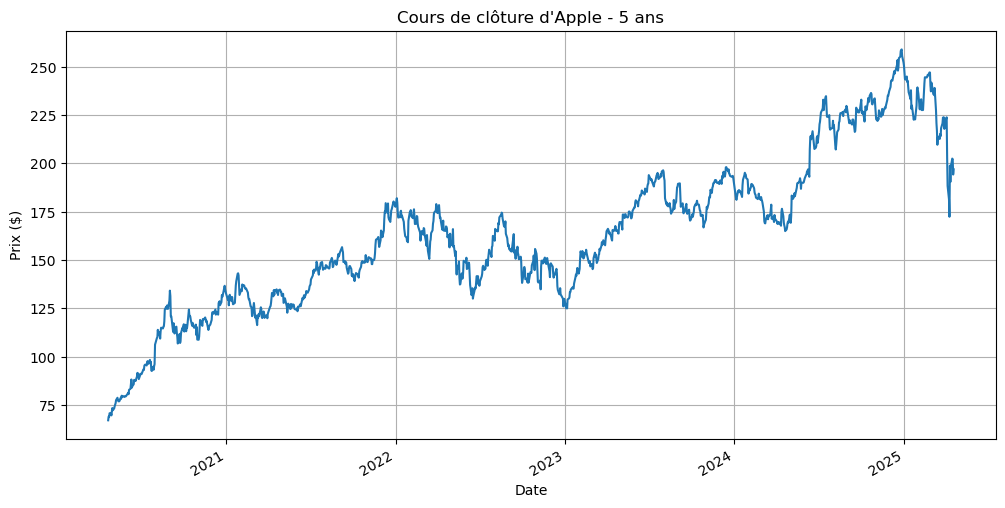

In [80]:
symbol = "AAPL"
# Période = 5 ans → environ 5 * 365 jours
period_days = 5 * 365
interval = "1d"

# Unix timestamp "from" = now - 5 years
end_time = int(time.time())
start_time = end_time - (period_days * 24 * 60 * 60)

url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?period1={start_time}&period2={end_time}&interval={interval}"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
data = response.json()

try:
    timestamps = data['chart']['result'][0]['timestamp']
    prices = data['chart']['result'][0]['indicators']['quote'][0]

    df = pd.DataFrame(prices)
    df['Date'] = pd.to_datetime(timestamps, unit='s')
    df.set_index('Date', inplace=True)

    df['close'] = df['close'].astype(float)
    print("✅ Données récupérées sur 5 ans")
    print(df.tail())

    # Affichage graphique
    df['close'].plot(title="Cours de clôture d'Apple - 5 ans", figsize=(12, 6))
    plt.xlabel("Date")
    plt.ylabel("Prix ($)")
    plt.grid()
    plt.show()

except Exception as e:
    print("❌ Erreur lors de la récupération :", e)
    print(data)
